# Load Packages

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

from scipy import stats
import statsmodels.api as sm

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.metrics.visualize import plot_tmlegain, plot_gain
from xgboost import XGBRegressor


from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMRegressor

# EDA

In [2]:
df = pd.read_csv('criteo-uplift-v2.1.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [4]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [5]:
print('Total number of samples: {}'.format(len(df)))

Total number of samples: 13979592


In [6]:
df['treatment'].value_counts(normalize = True)

treatment
1    0.85
0    0.15
Name: proportion, dtype: float64

In [7]:
print('Percentage of users that visit: {}%'.format(100*round(df['visit'].mean(),4)))
print('Percentage of users that convert: {}%'.format(100*round(df['conversion'].mean(),4)))
print('Percentage of visitors that convert: {}%'.format(100*round(df[df["visit"]==1]["conversion"].mean(),4)))

Percentage of users that visit: 4.7%
Percentage of users that convert: 0.29%
Percentage of visitors that convert: 6.21%


In [8]:
df.groupby('treatment').agg({'visit':['mean', 'sum', 'count']})

visit                  
               mean     sum     count
treatment                            
0          0.038201   80105   2096937
1          0.048543  576824  11882655

In [9]:
df.groupby('treatment').agg({'conversion':['mean', 'sum', 'count']})

conversion                 
                mean    sum     count
treatment                            
0           0.001938   4063   2096937
1           0.003089  36711  11882655

In [10]:
print(f'Difference in clickthrough rate between control and treatment: {np.round(df.groupby("treatment")["visit"].mean()[1] - df.groupby("treatment")["visit"].mean()[0], 4)}')
print(f'Difference in conversion between control and treatment: {np.round(df.groupby("treatment")["conversion"].mean()[1] - df.groupby("treatment")["conversion"].mean()[0], 4)}')

Difference in clickthrough rate between control and treatment: 0.0103
Difference in conversion between control and treatment: 0.0012


## Correlation of Variables

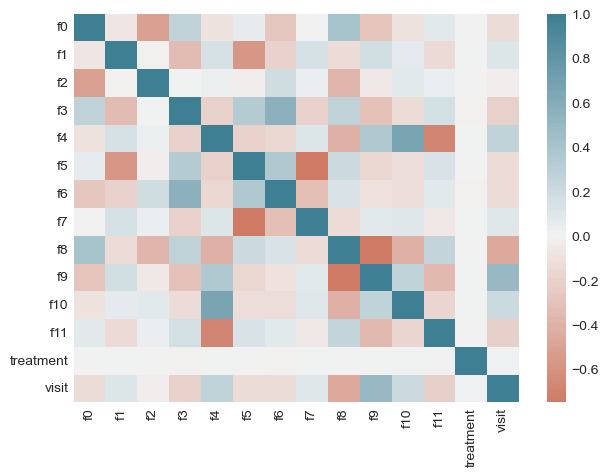

In [11]:
style.use('ggplot')
sns.set_style('whitegrid')

sns.heatmap(df.drop(columns=['conversion', 'exposure']).corr(), cmap=sns.diverging_palette(20, 220, n=200), center = 0, )
# plt.title("Correlation of all the variables")

plt.yticks(rotation=0)
plt.show()

# Estimating Average Treatment Effect

## Fisher Randomization Test

In [27]:
visit = df['visit']
treatment = df['treatment']

In [28]:
stats.ttest_ind(visit[treatment==1], visit[treatment==0], equal_var=True)


TtestResult(statistic=65.25736211515226, pvalue=0.0, df=13979590.0)

In [29]:
stats.ttest_ind(visit[treatment==1], visit[treatment==0], equal_var=False)


TtestResult(statistic=70.6851695931862, pvalue=0.0, df=3103528.3953319914)

In [30]:
stats.ranksums(visit[treatment==1], visit[treatment==0])


RanksumsResult(statistic=23.91576408992277, pvalue=2.0996396812919926e-126)

In [31]:
stats.kstest(visit[treatment==1], visit[treatment==0])

KstestResult(statistic=0.010342403129198208, pvalue=4.983383797366407e-166, statistic_location=0, statistic_sign=-1)

## Neymanian Inference

In [32]:
lm = sm.OLS(visit, sm.add_constant(treatment)).fit()


In [33]:
print("The estimated ATE is", lm.params['treatment'])
# Get HC2 robust standard errors
print("The robust standard error of estimated ATE is", np.sqrt(lm.cov_HC2[1,1]))

The estimated ATE is 0.010342403131967999
The robust standard error of estimated ATE is 0.00014631645069937803


## Model Adjustment

In [34]:
# Scale x (standardize)
x = df.drop(columns=['treatment', 'exposure', 'visit', 'conversion'])
x_scaled = (x - x.mean()) / x.std()

# Add interaction terms
interaction_terms = treatment.values.reshape(-1, 1) * x_scaled.values
interaction_df = pd.DataFrame(interaction_terms, columns=[f"{col}*z" for col in x.columns])

# Combine z, x, and interaction terms
x_combined = pd.concat([treatment, x_scaled, interaction_df], axis=1)
x_combined = sm.add_constant(x_combined)  # Add intercept

In [35]:
lm_adj = sm.OLS(visit, x_combined).fit()


In [36]:
print("The estimated ATE is", lm_adj.params['treatment'])
print("The robust standard error of estimated ATE is", np.sqrt(lm_adj.cov_HC2[1,1]))

The estimated ATE is 0.007733801745238557
The robust standard error of estimated ATE is 0.0001312566560357414


In [47]:
lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(x_scaled, treatment, visit)
print('Average Treatment Effect (Linear Regression): {:.4f} ({:.4f}, {:.4f})'.format(te[0], lb[0], ub[0]))


Average Treatment Effect (Linear Regression): 0.0070 (0.0067, 0.0072)


In [48]:

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(x_scaled, treatment, visit)
print('Average Treatment Effect (XGBoost): {:.4f} ({:.4f}, {:.4f})'.format(te[0], lb[0], ub[0]))


Average Treatment Effect (XGBoost): 0.0075 (0.0072, 0.0077)


In [50]:
nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
                 learning_rate_init=.1,
                 early_stopping=True,
                 random_state=42)
te, lb, ub = nn.estimate_ate(x_scaled, treatment, visit)
print('Average Treatment Effect (Neural Network (MLP)): {:.4f} ({:.4f}, {:.4f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Neural Network (MLP)): 0.0079 (0.0076, 0.0082)


In [53]:

xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
e = np.array([sum(treatment) / len(treatment)] * len(df))
te, lb, ub = xl.estimate_ate(x_scaled, treatment, visit, e)
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.4f} ({:.4f}, {:.4f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (BaseXRegressor using XGBoost): 0.0074 (0.0072, 0.0077)


In [ ]:
xl2 = BaseXRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = xl2.estimate_ate(x_scaled, treatment, visit)
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.4f} ({:.4f}, {:.4f})'.format(te[0], lb[0], ub[0]))

In [56]:

rl = BaseRRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub =  rl.estimate_ate(X=x_scaled, p=e, treatment=treatment, y=visit_test)
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.4f} ({:.4f}, {:.4f})'.format(te[0], lb[0], ub[0]))


Average Treatment Effect (BaseRRegressor using XGBoost): 0.0073 (0.0073, 0.0073)


In [ ]:
rl2 = BaseRRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub =  rl.estimate_ate(X=x_scaled, treatment=treatment, y=visit_test)
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.4f} ({:.4f}, {:.4f})'.format(te[0], lb[0], ub[0]))
